In [1]:
import os

In [2]:
len(os.listdir('/content/drive/MyDrive/self_made_ds/OverRipe'))

832

In [10]:
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import os

# 2: Load Data

In [11]:
data = tf.keras.utils.image_dataset_from_directory('/content/drive/MyDrive/self_made_ds')

Found 2477 files belonging to 3 classes.


In [12]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

In [13]:
classes = data.class_names
classes

['OverRipe', 'Ripe', 'UnRipe']

# Visualize Data

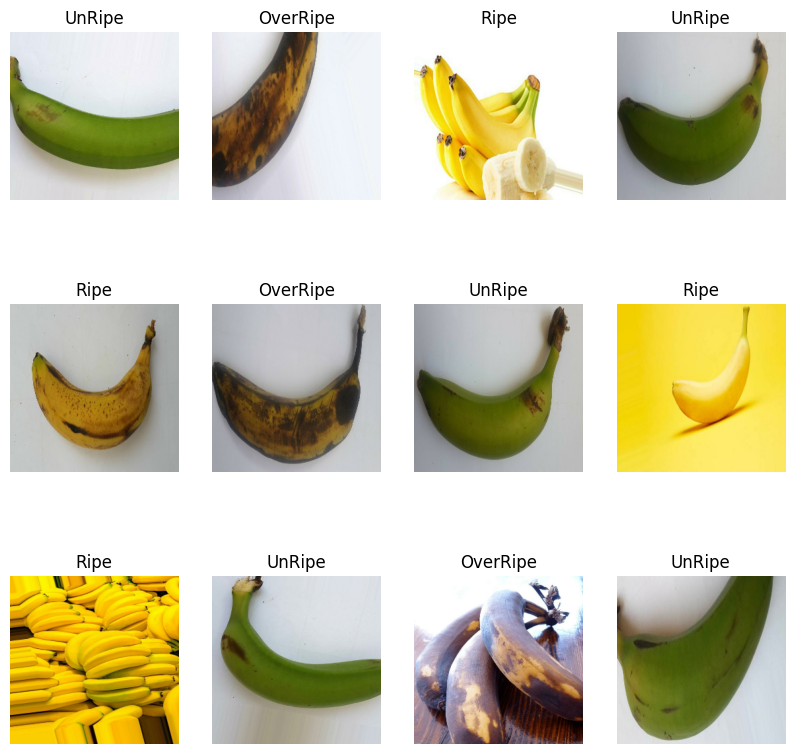

In [18]:
plt.figure(figsize =(10,10))

for image_batch, label_batch in data.take(1):
    for i in range(12):
        plt.subplot(3,4,i+1)
        plt.title(classes[label_batch[i]])
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")

# Scale Data

In [14]:
data = data.map(lambda x,y: (x/255, y))

In [ ]:
data.as_numpy_iterator().next()

# Split Data

In [15]:
def get_dataset_partitions(ds, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle = True, shuffle_size = 1000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 57)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [16]:
train, val, test = get_dataset_partitions(data)

In [17]:
print(len(train), len(val), len(test))

62 7 9


# Build VGG16 Model

In [25]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the base model's layers so they are not trainable
for layer in base_model.layers:
    layer.trainable = False

# Create a new model on top of the VGG16 base model
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(3, activation='softmax'))  # Adjust the number of classes accordingly

# Compile the model
model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 32768)             0         
                                                                 
 dense (Dense)               (None, 256)               8388864   
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 23,104,323
Trainable params: 8,389,635
Non-trainable params: 14,714,688
_________________________________________________________________


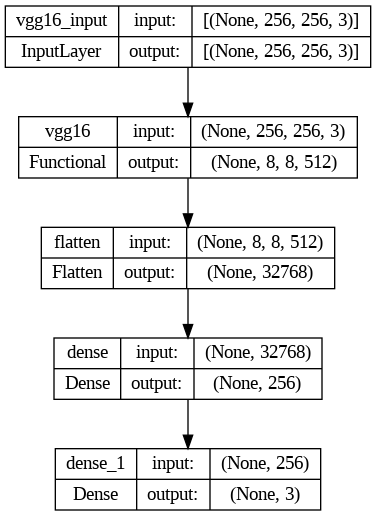

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file = 'model.png', show_shapes=True,show_layer_names=True)


In [27]:
hist = model.fit(train, epochs=20, validation_data=val)

Epoch 1/20
62/62 [==============================] - 60s 533ms/step - loss: 2.1686 - accuracy: 0.6560 - val_loss: 0.3602 - val_accuracy: 0.8482
Epoch 2/20
62/62 [==============================] - 32s 341ms/step - loss: 0.2453 - accuracy: 0.9160 - val_loss: 0.1514 - val_accuracy: 0.9509
Epoch 3/20
62/62 [==============================] - 32s 356ms/step - loss: 0.1372 - accuracy: 0.9669 - val_loss: 0.0877 - val_accuracy: 0.9911
Epoch 4/20
62/62 [==============================] - 32s 347ms/step - loss: 0.0820 - accuracy: 0.9858 - val_loss: 0.0452 - val_accuracy: 0.9955
Epoch 5/20
62/62 [==============================] - 34s 355ms/step - loss: 0.0485 - accuracy: 0.9954 - val_loss: 0.0397 - val_accuracy: 0.9955
Epoch 6/20
62/62 [==============================] - 33s 357ms/step - loss: 0.0333 - accuracy: 0.9959 - val_loss: 0.0179 - val_accuracy: 1.0000
Epoch 7/20
62/62 [==============================] - 33s 358ms/step - loss: 0.0189 - accuracy: 1.0000 - val_loss: 0.0153 - val_accuracy: 1.0000

In [28]:
test_loss, test_accuracy = model.evaluate(test)
print("test loss:",test_loss)
print("test accuracy:",test_accuracy)

9/9 [==============================] - 13s 158ms/step - loss: 0.0019 - accuracy: 1.0000
test loss: 0.0019015140132978559
test accuracy: 1.0


In [29]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

# Model Saving

In [30]:
model.save('/content/drive/MyDrive/New_VGG16.h5')

# Plot Performance

In [31]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

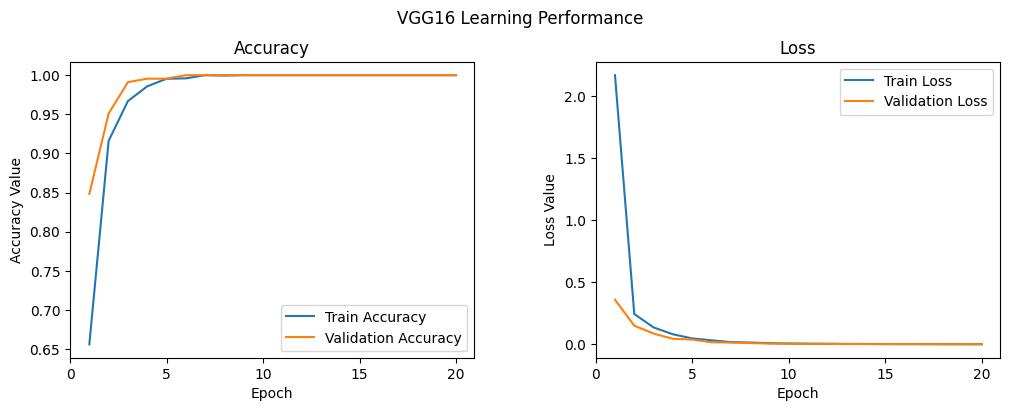

In [33]:
# Plot Accuracy and Loss
import matplotlib.pyplot as plt
epochs = 20
f, (ax1,ax2) = plt.subplots(1,2,figsize=(12,4))
t = f.suptitle('VGG16 Learning Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,epochs+1))
ax1.plot(epoch_list, acc, label='Train Accuracy')
ax1.plot(epoch_list, val_acc, label='Validation Accuracy')
ax1.set_xticks(np.arange(0,epochs+1,5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc='best')

ax2.plot(epoch_list, loss, label='Train Loss')
ax2.plot(epoch_list, val_loss, label='Validation Loss')
ax2.set_xticks(np.arange(0,epochs+1,5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc='best')

# Evaluate

In [35]:
from tensorflow.keras.metrics import CategoricalAccuracy, Precision, Recall

In [36]:
categorical_acc = CategoricalAccuracy()
precision = Precision()
recall = Recall()

In [37]:
for batch in test.as_numpy_iterator(): 
    X, y = batch
    yhat = model.predict(X)
    y_categorical = np.eye(3)[y]  # Convert categorical labels to one-hot encoded format
    categorical_acc.update_state(y_categorical, yhat)
    precision.update_state(y_categorical, yhat)
    recall.update_state(y_categorical, yhat)

accuracy = categorical_acc.result()
precision_result = precision.result()
recall_result = recall.result()


1/1 [==============================] - 0s 47ms/step


In [38]:
print("Accuracy:", accuracy)
print("Precision:", precision_result)
print("Recall:", recall_result)

Accuracy: tf.Tensor(1.0, shape=(), dtype=float32)
Precision: tf.Tensor(1.0, shape=(), dtype=float32)
Recall: tf.Tensor(1.0, shape=(), dtype=float32)


# Classification Report and Confusion Matrix

In [40]:
y_pred_classes = []
y_true_classes = []

for batch in test:
    X, y = batch
    y_pred = model.predict(X)
    y_pred_classes.extend(np.argmax(y_pred, axis=1))
    y_true_classes.extend(y)

y_pred_classes = np.array(y_pred_classes)
y_true_classes = np.array(y_true_classes)

print("y_pred_classes shape:", y_pred_classes.shape)
print("y_true_classes shape:", y_true_classes.shape)

1/1 [==============================] - 0s 49ms/step
y_pred_classes shape: (288,)
y_true_classes shape: (288,)


In [41]:
y_true_classes

array([1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2,
       0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1,
       0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2,
       2, 1, 2, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0, 2,
       0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2,
       2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 1,
       1, 0], dtype=int32)

In [42]:
y_pred_classes

array([1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 2, 0, 2, 0, 2, 1, 2,
       0, 1, 0, 0, 0, 0, 1, 1, 2, 2, 1, 0, 0, 2, 2, 0, 1, 2, 2, 1, 2, 2,
       0, 2, 1, 0, 2, 1, 2, 1, 2, 2, 2, 1, 2, 1, 1, 2, 2, 1, 2, 2, 2, 2,
       0, 0, 2, 0, 0, 0, 2, 1, 0, 2, 1, 0, 0, 0, 2, 0, 1, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1, 0, 2, 0, 2, 1, 1, 1, 2, 1, 1,
       2, 0, 1, 0, 1, 2, 2, 0, 1, 0, 1, 2, 2, 2, 0, 1, 1, 2, 2, 2, 0, 2,
       0, 0, 0, 1, 0, 0, 0, 2, 0, 2, 1, 2, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1,
       0, 0, 2, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 2, 0, 0, 2, 1, 2, 2, 0, 2,
       2, 1, 2, 0, 0, 2, 2, 1, 2, 1, 2, 1, 2, 1, 0, 0, 2, 0, 2, 2, 0, 2,
       0, 1, 0, 0, 2, 1, 2, 0, 1, 2, 2, 2, 2, 0, 0, 2, 2, 2, 1, 1, 2, 0,
       2, 0, 2, 0, 0, 0, 2, 1, 1, 1, 1, 2, 2, 2, 0, 1, 2, 2, 1, 1, 0, 2,
       2, 1, 0, 1, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 2, 2, 1, 2, 1,
       2, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 2, 0, 0, 1, 2, 0, 1,
       1, 0])

In [43]:
from sklearn.metrics import f1_score
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
print("f1 score:",f1)

f1 score: 1.0


In [44]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

Classification Report:
              precision    recall  f1-score   support

        ripe       1.00      1.00      1.00        95
      unripe       1.00      1.00      1.00        94
    overripe       1.00      1.00      1.00        99

    accuracy                           1.00       288
   macro avg       1.00      1.00      1.00       288
weighted avg       1.00      1.00      1.00       288



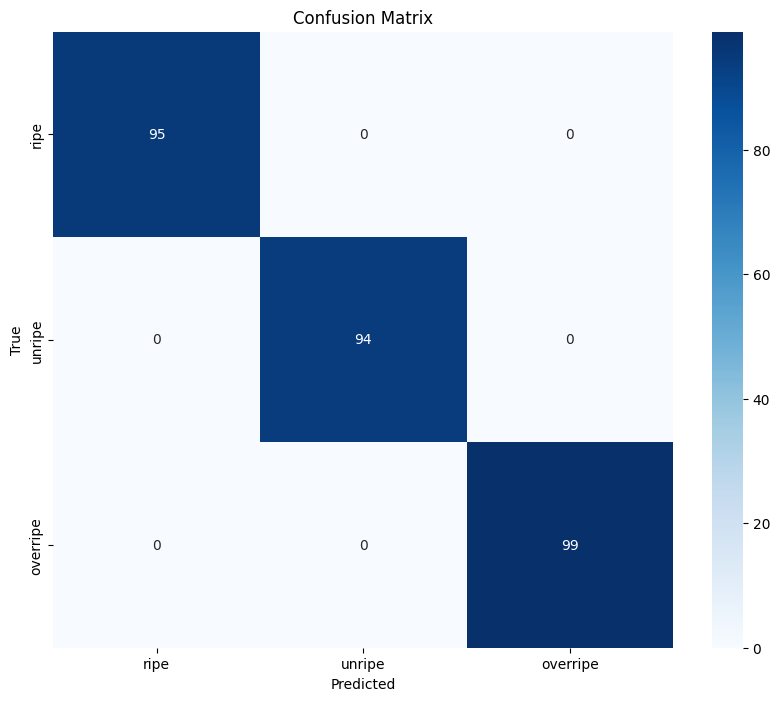

In [45]:
# Compute the classification report
class_names = ['ripe', 'unripe', 'overripe']
classification_rep = classification_report(y_true_classes, y_pred_classes, target_names=class_names)
print("Classification Report:")
print(classification_rep)

# Compute the confusion matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Loading the Model

In [5]:
from tensorflow.keras.models import load_model

pick_model = load_model('/content/drive/MyDrive/New_VGG16.h5')

# Test

In [18]:
import cv2

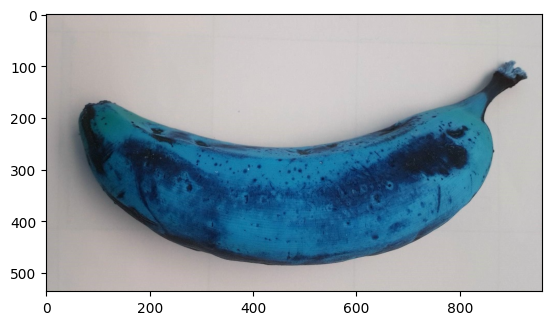

In [19]:
img = cv2.imread('/content/drive/MyDrive/self_made_ds/Ripe/115.jpeg')
plt.imshow(img)
plt.show()

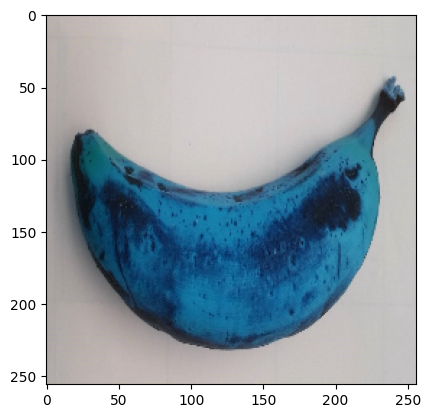

In [20]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [21]:
yhat = pick_model.predict(np.expand_dims(resize/255, 0))
yhat

1/1 [==============================] - 8s 8s/step


array([[9.7200203e-01, 2.7974419e-02, 2.3517108e-05]], dtype=float32)

In [22]:
class_indices = {0: 'Overripe', 1: 'Ripe', 2: 'Unripe'}
predicted_class_index = np.argmax(yhat)
predicted_class = class_indices[predicted_class_index]
print("Predicted class:", predicted_class)

Predicted class: Overripe


# Testing Predictions with Image Plotting

In [23]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)  # create a batch
    
    predictions = model.predict(img_array)
    
    predicted_label = classes[np.argmax(predictions[0])]
    confidence = round(100 *(np.max(predictions[0])), 2)
    return predicted_label, confidence

1/1 [==============================] - 0s 21ms/step


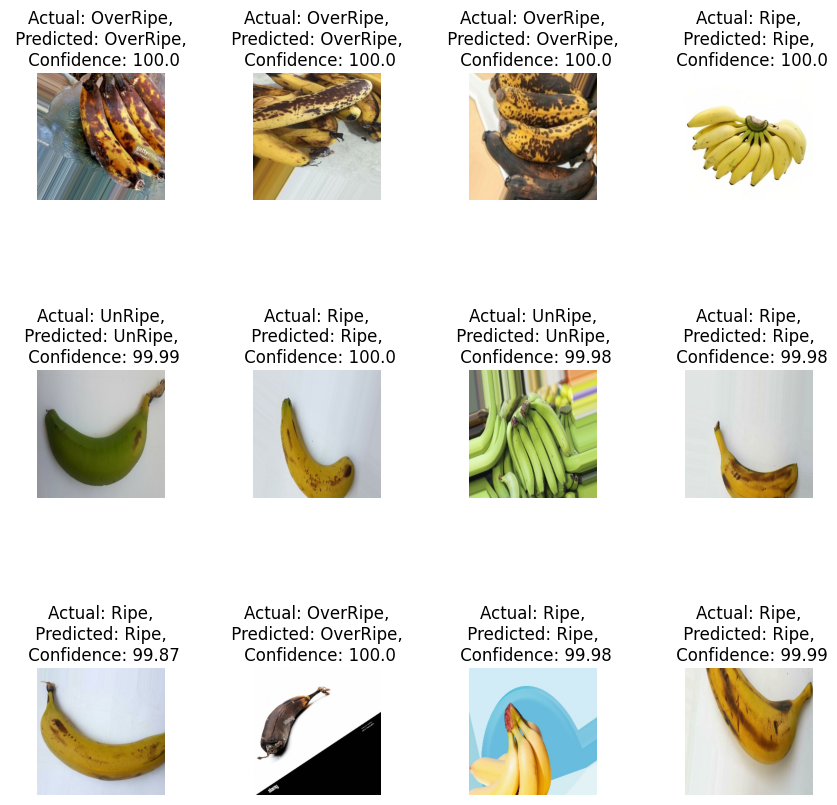

In [35]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(hspace=0.7, wspace=0.7)
for images, labels in test.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(images[i].numpy())
        
        pred_label, confidence = predict(pick_model, images[i])
        actual_label = classes[labels[i]]
        
        plt.title(f"Actual: {actual_label},\n Predicted: {pred_label}, \n Confidence: {confidence}")
        
        plt.axis('off')

# Building Dataframe for actual and predicted labels

In [39]:
import pandas as pd
import numpy as np

# Initialize an empty list to store the predicted and actual labels
predicted_labels = []
actual_labels = []

# Iterate over the test batches
for batch in test:
    batch_images, batch_labels = batch
    batch_predictions = pick_model.predict(batch_images)
    predicted_batch_labels = np.argmax(batch_predictions, axis=1)
    actual_batch_labels = batch_labels
    
    predicted_labels.extend(predicted_batch_labels)
    actual_labels.extend(actual_batch_labels)

# Convert the labels to class names
predicted_labels = [class_names[label] for label in predicted_labels]
actual_labels = [class_names[label] for label in actual_labels]

# Create a DataFrame with actual and predicted labels
predict_df = pd.DataFrame({'Target_Labels': actual_labels, 'Predictions': predicted_labels})
predict_df.head(20)


1/1 [==============================] - 0s 33ms/step


,Target_Labels,Predictions
0,Unripe,Unripe
1,Unripe,Unripe
2,Unripe,Unripe
3,ripe,ripe
4,Unripe,Unripe
5,Overripe,Overripe
6,ripe,ripe
7,Unripe,Unripe
8,ripe,ripe
9,Unripe,Unripe
